In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twittesentimentanalysis/tweets.csv


In [2]:
import numpy as np
import pandas as pd
import re   #pattern matching or search through
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
! pip install tqdm

In [4]:
from tqdm.notebook import tqdm

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
#read the dataset
df = pd.read_csv("/kaggle/input/twittesentimentanalysis/tweets.csv",encoding = 'ISO-8859-1')

In [8]:
# check the number of rows and columns
df.shape

(1599999, 6)

In [9]:
#print top rows
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
#name the columns
col_names = ['target','id','date','flag','user','text']
df = pd.read_csv("/kaggle/input/twittesentimentanalysis/tweets.csv",names = col_names, encoding = 'ISO-8859-1')

In [11]:
df.shape

(1600000, 6)

In [12]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
# counting the number of missing values 
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [14]:
#check the distribution of target columns
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [15]:
#converting target from 4 to 1
df.replace({'target':{4:1}},inplace=True)

**Stemming**

In [16]:
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

tqdm.pandas()  # Enable tqdm progress_apply
df['stemmed_content'] = df['text'].progress_apply(stemming)

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [17]:
df.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com y zl awww that s a...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can t updat hi facebook by te...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dive mani time for the ball manag t...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole bodi feel itchi and like it on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no it s not behav at all i m m...


In [18]:
print(df['stemmed_content'])

0          switchfoot http twitpic com y zl awww that s a...
1          is upset that he can t updat hi facebook by te...
2          kenichan i dive mani time for the ball manag t...
3               my whole bodi feel itchi and like it on fire
4          nationwideclass no it s not behav at all i m m...
                                 ...                        
1599995    just woke up have no school is the best feel ever
1599996    thewdb com veri cool to hear old walt intervie...
1599997    are you readi for your mojo makeov ask me for ...
1599998    happi th birthday to my boo of alll time tupac...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [19]:
#separating data and label
X = df['stemmed_content'].values
y = df['target'].values

In [20]:
print(X)

['switchfoot http twitpic com y zl awww that s a bummer you shoulda got david carr of third day to do it d'
 'is upset that he can t updat hi facebook by text it and might cri as a result school today also blah'
 'kenichan i dive mani time for the ball manag to save the rest go out of bound'
 ... 'are you readi for your mojo makeov ask me for detail'
 'happi th birthday to my boo of alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [21]:
print(y)

[0 0 0 ... 1 1 1]


In [22]:
X.shape

(1600000,)

**Splitting into training and test data**

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=43)
#stratify = equal distribution of 1 and 0 in test data as well

In [24]:
print(X_train.shape,X_test.shape)

(1280000,) (320000,)


In [25]:
X_test

array(['spencerpratt u should go to topshop',
       'lol pay for those abort brennan',
       'bzmclaughlin then quot twitter quot it shall be', ...,
       'watch tri to find kriswilliam in a bar scene',
       'hilari s grad parti senior',
       'clifsoulo aw i hate it when i becom quot that quot kind of girl it happen'],
      dtype=object)

**Converting Textual to numerical data**

In [26]:
vectorizer = TfidfVectorizer()
# train test needs to be fit and transform where as test data is only tensformed
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [27]:
print(X_train)

  (0, 93734)	0.1953940244259041
  (0, 304633)	0.30716725213947654
  (0, 400988)	0.12087023679611819
  (0, 439254)	0.6120651370848155
  (0, 275899)	0.3641897648809213
  (0, 354578)	0.3180623203069973
  (0, 413724)	0.3287688120604728
  (0, 453439)	0.2756175189259111
  (0, 299210)	0.24573224307832975
  (1, 232107)	0.9206998721976809
  (1, 280985)	0.20768646558399373
  (1, 267656)	0.3304210606913593
  (2, 57548)	0.26598203408022736
  (2, 109537)	0.36504602715649576
  (2, 136007)	0.1583566711610987
  (2, 400405)	0.22222592278149184
  (2, 404291)	0.23537409926701472
  (2, 163506)	0.34276513300401185
  (2, 86536)	0.7407056477018906
  (3, 138666)	0.5815588668020486
  (3, 406657)	0.36033811100716495
  (3, 375741)	0.2353136626626136
  (3, 328788)	0.5815588668020486
  (3, 245540)	0.23296331399873102
  (3, 42965)	0.20975554295368154
  :	:
  (1279997, 129219)	0.26029252384606566
  (1279997, 124407)	0.1875720060783265
  (1279997, 40014)	0.16905718770437209
  (1279997, 241937)	0.12941682359475168
  (

In [28]:
print(X_test)

  (0, 413317)	0.639123775441555
  (0, 410982)	0.13669735063493535
  (0, 378497)	0.6520386990636048
  (0, 366094)	0.3197331633601728
  (0, 149724)	0.2131921039012961
  (1, 406989)	0.3168803048289626
  (1, 310756)	0.34993481033236185
  (1, 239683)	0.22566463330588526
  (1, 136007)	0.1596348181021571
  (1, 51395)	0.6197696992590671
  (1, 1938)	0.5626812765090861
  (2, 420754)	0.3261371729394035
  (2, 403668)	0.33106034835025816
  (2, 361519)	0.5150548002757593
  (2, 329779)	0.6536303504608081
  (2, 183673)	0.18186155173495705
  (2, 35311)	0.24175583518755395
  (3, 442258)	0.16340662290596691
  (3, 441107)	0.2419412027298665
  (3, 435821)	0.5125292210011894
  (3, 410982)	0.08257888701568154
  (3, 403668)	0.17922389348456308
  (3, 373430)	0.4447795479310646
  (3, 280985)	0.10033094938240181
  (3, 178973)	0.11301598722262234
  :	:
  (319996, 13245)	0.2728022896274167
  (319997, 436543)	0.2391677695054045
  (319997, 415971)	0.26075314943494043
  (319997, 410982)	0.1161199896218741
  (319997, 

**Train the Macine Learning Model Logistic Regression**

In [29]:
model = LogisticRegression(max_iter = 1000)

In [30]:
print(X_train.shape,y_train.shape)


(1280000, 461276) (1280000,)


In [31]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

**Model Evaluation**

In [32]:
#accuracy score
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(y_train,X_train_prediction)

In [33]:
print('Accuracy score in the training data : ', training_data_accuracy)

Accuracy score in the training data :  0.82156875


In [34]:
#accuracy score on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(y_test,X_test_prediction)

In [35]:
print('Accuracy score in the test data by Logistic Regression: ', test_data_accuracy)

Accuracy score in the test data by Logistic Regression:  0.79619375


**Using model as Naive Bayes**

In [36]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(y_test,X_test_prediction)
print('Accuracy score in the test data by Naive Bayes : ', test_data_accuracy)

Accuracy score in the test data by Naive Bayes :  0.79619375


**Confusion_Matrix**

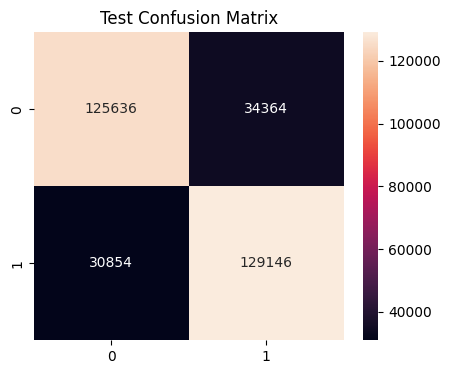

In [37]:
cm = confusion_matrix(y_test,X_test_prediction)
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

**Savig this trained model**

In [38]:
import pickle

In [39]:
filename = 'trained_model.sav'
pickle.dump(model,open(filename,'wb'))#r-only read, w-write and b-binary form

**Using the saved model**

In [40]:
#loading the saved model
loaded_model = pickle.load(open('/kaggle/working/trained_model.sav','rb'))

In [41]:
X_new =X_test[200]
print(y_test[200])
prediction = loaded_model.predict(X_new)
print(prediction)

if(prediction[0] == 0):
    print('Negative tweet')
else:
    print('Positive tweet')

0
[0]
Negative tweet


In [42]:
X_new =X_test[34]
print(y_test[34])
prediction = loaded_model.predict(X_new)
print(prediction)

if(prediction[0] == 0):
    print('Negative tweet')
else:
    print('Positive tweet')

1
[1]
Positive tweet
